In [72]:
import cv2 as cv2
import matplotlib.pyplot as plt
import numpy as np
import math

In [1]:
#案例一，paper矫正

1
(1211, 1, 2)
[[[203  15]]

 [[ 14 464]]

 [[340 593]]

 [[514 146]]]


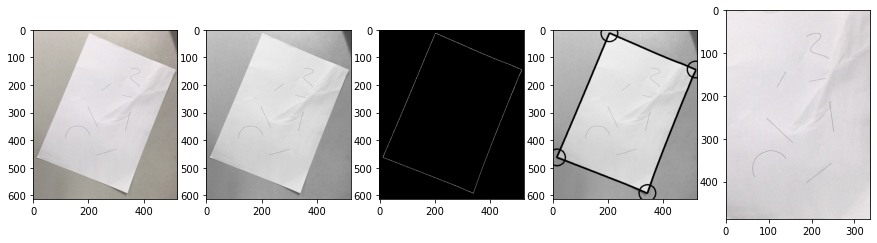

In [73]:
#练习改进
fig, axes = plt.subplots(1, 5, figsize=(15, 15))
img = cv2.imread('../data/paper.jpg', 1)[..., ::-1]
axes[0].imshow(img)

gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
axes[1].imshow(gray, cmap=plt.get_cmap('gray'))

#模糊降噪
bluerd = cv2.GaussianBlur(gray, (5, 5), 0)

# 执行开运算,去掉边角的阴影
k = np.ones((3, 3), np.uint8)
r1 = cv2.morphologyEx(bluerd, cv2.MORPH_CLOSE, k, iterations=3)

#提高边沿分辨度
canny = cv2.Canny(r1,
                  30,  #滞后域值
                  120)  #模糊度

t, binary = cv2.threshold(canny, 200, 255, cv2.THRESH_BINARY)
axes[2].imshow(binary, cmap=plt.get_cmap('gray'))

cnts, hie = cv2.findContours(binary,
                             mode=cv2.RETR_EXTERNAL,  #只检测外轮廓
                             method=cv2.CHAIN_APPROX_SIMPLE)  #存储重点坐标

#print(len(cnts))
#for i in range(len(cnts)):
#    print(cnts[i].shape)

#找到最大的矩形轮廓，并获得矩形坐标
doccnt = None
if len(cnts) > 0:
    sorted(cnts,
           key=cv2.contourArea,  #key只能是排序依据，所以不用（），有了（）就是函数调用了
           reverse=True)  #降序排序
    for cnt in cnts:
        eps = 0.02 * cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, eps, True)
        if len(approx) == 4:
            doccnt = approx
            break

print(doccnt)

points = []
for peak in doccnt:
    peak = peak[0]
    cv2.circle(gray, tuple(peak), 30, (0, 0, 0), 4)
    points.append(peak)
#变换之前的坐标点
src = np.array(points, dtype='float32')

#求宽度和高度
h = int(math.sqrt((src[0][0] - src[1][0]) ** 2 + (src[0][1] - src[1][1]) ** 2))
w = int(math.sqrt((src[0][0] - src[3][0]) ** 2 + (src[0][1] - src[3][1]) ** 2))

dst = np.float32([[0, 0],
                  [0, h],
                  [w, h],
                  [w, 0]])

M = cv2.getPerspectiveTransform(src, dst)
res = cv2.warpPerspective(img, M, (w, h))
axes[4].imshow(res)

#绘制轮廓
img_cnt = cv2.drawContours(gray,
                           cnts[0],
                           -1,  # 绘制cnts内全部轮廓
                           (0, 0, 0),  # 轮廓颜色：黑色
                           6)  # 轮廓粗细 -1表示实心化填充

axes[3].imshow(img_cnt, cmap=plt.get_cmap('gray'))
plt.show()

In [ ]:
#案例二检测芯片瑕疵

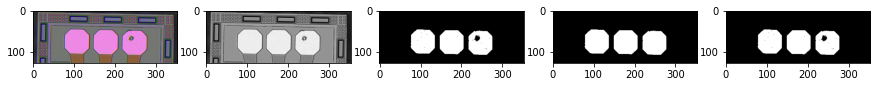

In [154]:
#练习
fig, axes = plt.subplots(1, 5, figsize=(15, 15))
img = cv2.imread('../data/CPU3.png', 1)[..., ::-1]
axes[0].imshow(img)

gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
axes[1].imshow(gray, cmap=plt.get_cmap('gray'))

t, binary = cv2.threshold(gray, 169, 255, cv2.THRESH_BINARY)
axes[2].imshow(binary, cmap=plt.get_cmap('gray'))

cnts, hie = cv2.findContours(binary,
                             mode=cv2.RETR_EXTERNAL,  #只检测外轮廓
                             method=cv2.CHAIN_APPROX_NONE)  #存储所有的轮廓点

#print(type(cnts))
#print(len(cnts))
#print(cnts[0])
#for i in range(len(cnts)):
#    print(cnts[i].shape)
#print(hie)
binary2 = binary.copy()
axes[4].imshow(binary2, cmap=plt.get_cmap('gray'))
#绘制轮廓
img_cnt = cv2.drawContours(binary, cnts,
                           -1,  # 绘制全部轮廓
                           (255, 255, 0),  # 轮廓颜色：红色
                           -1)  # 轮廓粗细

axes[3].imshow(img_cnt, cmap=plt.get_cmap('gray'))
plt.show()

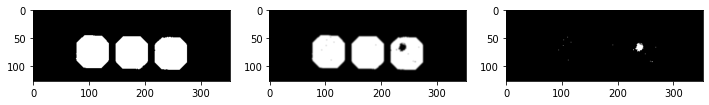

In [155]:
#模糊降噪
#bluerd = cv2.GaussianBlur(binary2, (5, 5), 1)
dst = cv2.subtract(binary, binary2)  # 两幅图像相减，是求出图像的差异

fig, axes = plt.subplots(1, 3, figsize=(12, 12))
axes[0].imshow(binary, cmap=plt.get_cmap('gray'))
axes[1].imshow(bluerd, cmap=plt.get_cmap('gray'))
axes[2].imshow(dst, cmap=plt.get_cmap('gray'))
plt.show()

3
圆心和半径：((246.57955932617188, 77.20622253417969),35.37987518310547)


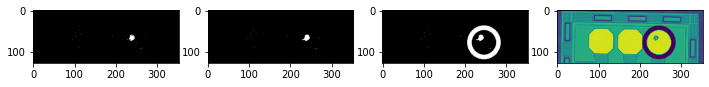

In [156]:
# 执行闭运算
k = np.ones((3, 3), np.uint8)
r1 = cv2.morphologyEx(dst, cv2.MORPH_CLOSE, k, iterations=3)
fig, axes = plt.subplots(1, 4, figsize=(12, 12))

axes[0].imshow(dst, cmap=plt.get_cmap('gray'))
axes[1].imshow(r1, cmap=plt.get_cmap('gray'))

#查找轮廓
cnts, hie = cv2.findContours(bluerd,
                             mode=cv2.RETR_EXTERNAL,  #只检测外轮廓
                             method=cv2.CHAIN_APPROX_NONE)  #存储所有的轮廓点

print(len(cnts))

center, radius = cv2.minEnclosingCircle(cnts[0])

print('圆心和半径：({},{})'.format(center, radius))
#圆心和半径必须是整数
center = (int(center[0]), int(center[1]))
radius = int(radius)

img_cnt = cv2.circle(r1, center, radius, (255, 255, 255), 10)
axes[2].imshow(img_cnt, cmap=plt.get_cmap('gray'))

img_cnt2 = cv2.circle(gray, center, radius, (0, 0, 0), 10)
axes[3].imshow(img_cnt2)

plt.show()

In [146]:
#答案

圆心和半径：((261.5, 92.0),0.5001000165939331)


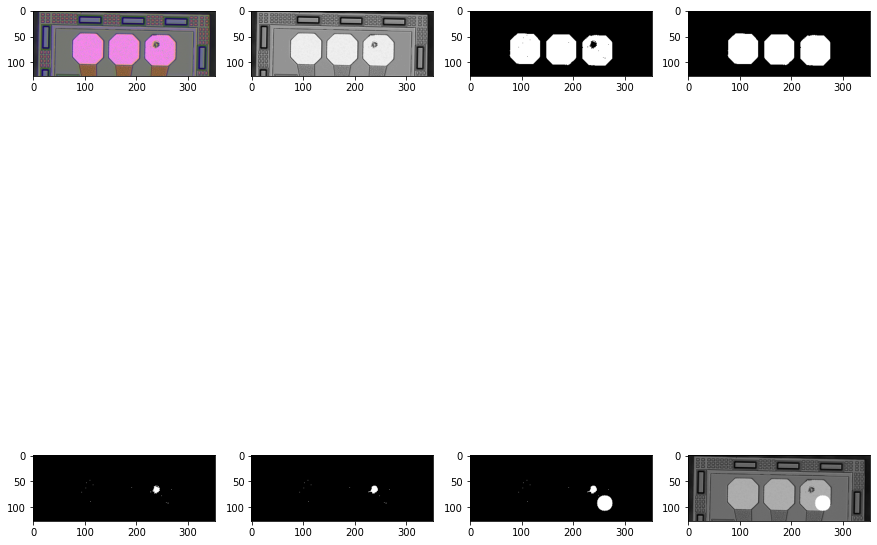

In [180]:
#练习
fig, axes = plt.subplots(2, 4, figsize=(15, 15))
img = cv2.imread('../data/CPU3.png', 1)[..., ::-1]
axes[0][0].imshow(img)

gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
axes[0][1].imshow(gray, cmap=plt.get_cmap('gray'))

t, binary = cv2.threshold(gray, 169, 255, cv2.THRESH_BINARY)
axes[0][2].imshow(binary, cmap=plt.get_cmap('gray'))

cnts, hie = cv2.findContours(binary,
                             mode=cv2.RETR_EXTERNAL,  #只检测外轮廓
                             method=cv2.CHAIN_APPROX_NONE)  #存储所有的轮廓点

mask = np.zeros_like(binary)
#绘制轮廓
img_fill = cv2.drawContours(mask, cnts,
                            -1,  # 绘制全部轮廓
                            (255, 0, 0),  # 轮廓颜色：红色
                            -1)  # 轮廓粗细
axes[0][3].imshow(img_cnt, cmap=plt.get_cmap('gray'))

img_sub = cv2.subtract(img_fill, binary)  # 两幅图像相减，是求出图像的差异
axes[1][0].imshow(img_sub, cmap=plt.get_cmap('gray'))

# 执行闭运算
k = np.ones((3, 3), np.uint8)
close = cv2.morphologyEx(img_sub, cv2.MORPH_CLOSE, k, iterations=2)
axes[1][1].imshow(close, cmap=plt.get_cmap('gray'))

#查找轮廓
cnts, hie = cv2.findContours(close,
                             mode=cv2.RETR_EXTERNAL,  #只检测外轮廓
                             method=cv2.CHAIN_APPROX_NONE)  #存储所有的轮廓点

#找到最大的矩形轮廓
doccnt = None
if len(cnts) > 0:
    sorted(cnts,
           key=cv2.contourArea,  #key只能是排序依据，所以不用（），有了（）就是函数调用了
           reverse=True)  #降序排序

center, radius = cv2.minEnclosingCircle(cnts[0])
print('圆心和半径：({},{})'.format(center, radius))
#圆心和半径必须是整数
center = (int(center[0]), int(center[1]))
radius = int(radius)

img_close = cv2.circle(close, center, radius, (255, 255, 255), 30)  # 绘制圆
axes[1][2].imshow(img_close, cmap=plt.get_cmap('gray'))

img_close2 = cv2.circle(gray, center, radius, (255, 255, 255), 30)  # 绘制圆
axes[1][3].imshow(img_close2, cmap=plt.get_cmap('gray'))

plt.show()